# NLP project: detection of texts, generated by bots, in social networks on Russian



First, set-up environment and required imports

In [ ]:
## Set-up environment
# pip install accelerate -U

In [ ]:
# pip install transformers[torch]

In [ ]:
# pip install -q transformers datasets

In [ ]:
# pip install googletrans==3.1.0a0

In [ ]:
import torch
from torch.utils.data import DataLoader
import random
import re
import pandas as pd
import numpy as np
import math
from transformers import AutoTokenizer, AutoModel,  AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils import clip_grad_norm_
from scipy.sparse import hstack
import datasets
from datasets import Dataset
from transformers import pipeline
from googletrans import Translator
from tqdm.auto import tqdm
from tqdm.notebook import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import nltk, string
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Dataset collection

In [ ]:
# first dataset contains tweets on Russian (human-generated), link https://github.com/sismetanin/rusentitweet
dataset1 = pd.read_csv("rusentitweet_full.csv")

In [ ]:
# I have reviewed this dataset1, and as result I was doubt, that tweets labelled as "skip" is really written by human =>
# and just in case I have deleted these samples (but may be it is not required)
dataset1 = dataset1[dataset1.label != "skip"]

In [ ]:
dataset1 = dataset1[['text', 'label']]

In [ ]:
# second part of dataset is English tweets labelled 1 for bot-generated and 0 for human-generated
# source: https://www.kaggle.com/datasets/goyaladi/twitter-bot-detection-dataset/?select=bot_detection_data.csv
dataset2 = pd.read_csv('bot_detection_data.csv')

In [ ]:
dataset2 = dataset2.rename(columns={"Bot Label": "label"})

In [ ]:
# translation
translator = Translator()
dataset2_ru = pd.DataFrame(columns=['comment', 'label'])
for index, row in dataset2.iterrows():
    dataset2_ru.loc[index + 1] = [translator.translate(row['Tweet'], dest='ru').text] + [row['label']]

In [ ]:
# translated dataset I have read in excel format and correct phrases, if needed
dataset2_ru.to_csv('train_ru.csv', index=False)

In [ ]:
# read corrected dataset after translation
databot = pd.read_csv("train_ru_final.csv")

In [ ]:
databot.rename(columns={'comment':'text'}, inplace=True)

In [ ]:
# add to dataset1 additional tweets human-generated from translated English dataset
dataman = databot.loc[databot['label'] == 0]
dataman = dataman[:5000]
dataset1 = dataset1.append(dataman)

In [ ]:
# add to dataset1 additional tweets bot-generated from translated English dataset, such that classes will be balanced
databot2=databot.loc[databot['label'] == 1]
databot2 = databot2[:16500]
dataset1 = dataset1.append(databot2)

In [ ]:
# save final dataset for further work
dataset1.to_csv('dataset4bot_detection.csv', index=False)

In [ ]:
# read dataset and check statistic
dataset = pd.read_csv("dataset4bot_detection.csv")

In [ ]:
dataset.head(3)

,text,label
0,велл они всё равно что мусор так что ничего с...,0
1,"""трезвая жизнь какая-то такая стрёмная""\r\n(с)...",0
2,Ой какие неожиданные результаты 🤭 https://t.co...,0


In [ ]:
dataset.shape

(33049, 2)

In [ ]:
dataset['label'].value_counts()

0    16549
1    16500
Name: label, dtype: int64

Text(0.5, 1.0, 'Target distribution')

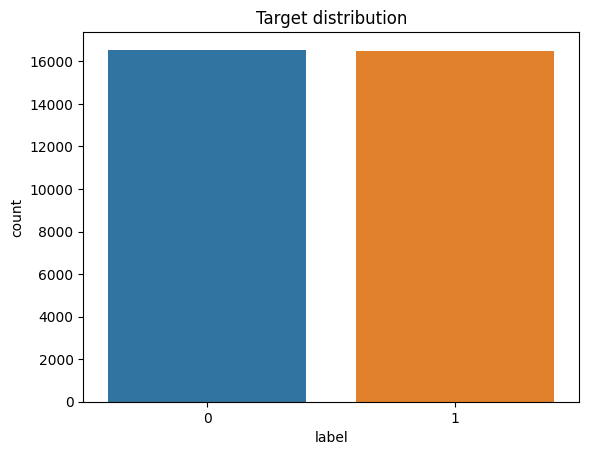

In [ ]:
sns.countplot(x=dataset.label)
plt.title('Target distribution')

In [ ]:
# split on train and test
train, val = train_test_split(dataset, test_size=0.1, random_state=42, stratify=dataset['label'])
print(f'Train size:\t{train.shape[0]}\nTest size:\t{val.shape[0]}')

Train size:	29744
Test size:	3305


## Main part



## TF-IDF Logistic Regression

In [ ]:
def preprosess_text(df):

    urls_regex = r'http\S+'
    mentions_regex = r'@\S+'
    hashtags_regex = r'#\S+'
    enter_regex = r'\n'
    punct_regex = '\[[^]]*\]'

    patterns = "|".join([urls_regex, mentions_regex, hashtags_regex, enter_regex, punct_regex])
    clean_text = lambda t: re.sub(patterns, "", t)
    dataset['text'] = dataset['text'].apply(clean_text)

    return df

In [ ]:
df_train = preprosess_text(train)
df_test = preprosess_text(val)

In [ ]:
nltk.download("stopwords")
ru_stopwords = list(stopwords.words('russian'))

print(ru_stopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
text_transformer = TfidfVectorizer(stop_words=ru_stopwords, ngram_range=(1, 1), lowercase=True)

In [ ]:
X_train_text = text_transformer.fit_transform(df_train['text'])
X_test_text = text_transformer.transform(df_test['text'])

In [ ]:
logit = LogisticRegression(C=5e1, solver='lbfgs', random_state=17, n_jobs= -1)
logit.fit(X_train_text, df_train['label'])

LogisticRegression(C=50.0, n_jobs=-1, random_state=17)

In [ ]:
test_preds = logit.predict(X_test_text)

In [ ]:
print('classifiation report')
print(classification_report(test_preds, df_test['label'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1508
           1       0.86      0.79      0.82      1797

    accuracy                           0.81      3305
   macro avg       0.81      0.81      0.81      3305
weighted avg       0.82      0.81      0.81      3305



## Preparation for transformer's dataloader

In [ ]:
def tokenize_function(examples):

    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [ ]:
train_data = Dataset.from_dict(train[['label', 'text']])
val_data = Dataset.from_dict(val[['label', 'text']])

In [ ]:
dataset = datasets.DatasetDict({"train":train_data, "test": val_data})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 29744
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 3305
    })
})

In [ ]:
dataset.set_format(type="pandas")
train_df = dataset['train'][:]
valid_df = dataset['test'][:]

## rubert_tiny2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
PRETRAINED_LM_2 = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(
    PRETRAINED_LM_2, truncation=True, do_lower_case=True)
tokenizer

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='cointegrated/rubert-tiny2', vocab_size=83828, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())

In [ ]:
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())

train_y.size(),valid_y.size()

(torch.Size([29744]), torch.Size([3305]))

In [ ]:
BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [ ]:
N_labels = len(train_df.label.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM_2,
                                                      num_labels=N_labels,
                                                      ignore_mismatched_sizes=True,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
EPOCHS = 5
LEARNING_RATE = 2e-6
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [ ]:
train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/1859 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

1859/1859 train loss: 0.49054712003408546 
207/207 val loss: 0.37599553534950036 
Epoch:  2


Training:   0%|          | 0/1859 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

1859/1859 train loss: 0.39188967054011425 
207/207 val loss: 0.3568812531693546 
Epoch:  3


Training:   0%|          | 0/1859 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

1859/1859 train loss: 0.3804218116796998 
207/207 val loss: 0.3491412333892163 
Epoch:  4


Training:   0%|          | 0/1859 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

1859/1859 train loss: 0.3743046239347083 
207/207 val loss: 0.3460972692439522 
Epoch:  5


Training:   0%|          | 0/1859 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

1859/1859 train loss: 0.37240931044636777 
207/207 val loss: 0.34513226680565573 


In [ ]:
print('classifiation report')
print(classification_report(valid_pred, valid_df['label'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1208
           1       1.00      0.78      0.88      2097

    accuracy                           0.86      3305
   macro avg       0.86      0.89      0.86      3305
weighted avg       0.90      0.86      0.86      3305



In [ ]:
model_path = "/small_bert"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/NLP course/Bot_detection/small_bert/tokenizer_config.json',
 '/content/drive/MyDrive/NLP course/Bot_detection/small_bert/special_tokens_map.json',
 '/content/drive/MyDrive/NLP course/Bot_detection/small_bert/vocab.txt',
 '/content/drive/MyDrive/NLP course/Bot_detection/small_bert/added_tokens.json',
 '/content/drive/MyDrive/NLP course/Bot_detection/small_bert/tokenizer.json')

## ruBert-base

In [ ]:
PRETRAINED_LM = "ai-forever/ruBert-base"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

BertTokenizer(name_or_path='ai-forever/ruBert-base', vocab_size=120138, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())

In [ ]:
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())

train_y.size(),valid_y.size()

(torch.Size([29744]), torch.Size([3305]))

In [ ]:
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [ ]:
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/1859 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

1859/1859 train loss: 0.38649405523004426 
207/207 val loss: 0.3375937930051831 
Epoch:  2


Training:   0%|          | 0/1859 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

1859/1859 train loss: 0.359578500845985 
207/207 val loss: 0.33490116347149373 
Epoch:  3


Training:   0%|          | 0/1859 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

1859/1859 train loss: 0.3515338947622766 
207/207 val loss: 0.33592355344894426 
Epoch:  4


Training:   0%|          | 0/1859 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

1859/1859 train loss: 0.34447096014067713 
207/207 val loss: 0.3372831280176766 
Epoch:  5


Training:   0%|          | 0/1859 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

1859/1859 train loss: 0.3385536911956978 
207/207 val loss: 0.3380109973359799 


In [ ]:
print('classifiation report')
print(classification_report(valid_pred, valid_df['label'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1213
           1       1.00      0.79      0.88      2092

    accuracy                           0.86      3305
   macro avg       0.86      0.89      0.86      3305
weighted avg       0.90      0.86      0.87      3305



In [ ]:
model_path = "/ruBert"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/NLP_course_project/sberAVG/tokenizer_config.json',
 '/content/drive/MyDrive/NLP_course_project/sberAVG/special_tokens_map.json',
 '/content/drive/MyDrive/NLP_course_project/sberAVG/vocab.txt',
 '/content/drive/MyDrive/NLP_course_project/sberAVG/added_tokens.json')

## rubert_tiny2 on augmented train

In [ ]:
# approach for augmentation was described in Report
# Augmentation was done on initially Russian tweets (in Excel file)
dataset_aug = pd.read_csv("rusentitweet_full_augmented.csv")

In [ ]:
#also increased dataset from translated English dataset, but such, that classes will be in-balance
databot = pd.read_csv("train_ru_final.csv")
databot.rename(columns={'comment':'text'}, inplace=True)
dataman = databot.loc[databot['label'] == 0]
dataman = dataman[:6300]
dataset_aug = dataset_aug.append(dataman)

databot2=databot.loc[databot['label'] == 1]
dataset_aug = dataset_aug.append(databot2)

In [ ]:
dataset_aug.to_csv('dataset4bot_augmented.csv', index=False)

In [ ]:
dataset_aug = pd.read_csv("dataset4bot_augmented.csv")

In [ ]:
train_aug, val_aug = train_test_split(dataset_aug, test_size=0.1, random_state=42, stratify=dataset_aug['label'])
print(f'Train augmented size:\t{train_aug.shape[0]}')

Train augmented size:	52764


In [ ]:
train_data = Dataset.from_dict(train_aug[['label', 'text']])
val_data = Dataset.from_dict(val[['label', 'text']])

In [ ]:
dataset = datasets.DatasetDict({"train":train_data, "test": val_data})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 52764
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 3305
    })
})

In [ ]:
dataset.set_format(type="pandas")
train_df = dataset['train'][:]
valid_df = dataset['test'][:]

In [ ]:
PRETRAINED_LM_1 = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(
    PRETRAINED_LM_1, truncation=True, do_lower_case=True)
tokenizer

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='cointegrated/rubert-tiny2', vocab_size=83828, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())

In [ ]:
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())

train_y.size(),valid_y.size()

In [ ]:
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [ ]:
N_labels = len(train_df.label.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM_1,
                                                      num_labels=N_labels,
                                                      ignore_mismatched_sizes=True,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [ ]:
train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/3298 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

3298/3298 train loss: 0.39210835272268935 
207/207 val loss: 0.36552413315444754 
Epoch:  2


Training:   0%|          | 0/3298 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

3298/3298 train loss: 0.3059812865365159 
207/207 val loss: 0.34783934135943795 
Epoch:  3


Training:   0%|          | 0/3298 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

3298/3298 train loss: 0.2963689337611614 
207/207 val loss: 0.34546814369406675 
Epoch:  4


Training:   0%|          | 0/3298 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

3298/3298 train loss: 0.2940217805388138 
207/207 val loss: 0.34531221389410577 
Epoch:  5


Training:   0%|          | 0/3298 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

3298/3298 train loss: 0.29214976828606326 
207/207 val loss: 0.3443900765716166 


In [ ]:
print('classifiation report')
print(classification_report(valid_pred, valid_df['label'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      2318
           1       1.00      0.77      0.87      4292

    accuracy                           0.85      6610
   macro avg       0.85      0.88      0.85      6610
weighted avg       0.89      0.85      0.85      6610



In [ ]:
model_path3 = "small_bert_augmented"
model.save_pretrained(model_path3)
tokenizer.save_pretrained(model_path3)

('/content/drive/MyDrive/NLP course/Bot_detection/small_bert_augmented/tokenizer_config.json',
 '/content/drive/MyDrive/NLP course/Bot_detection/small_bert_augmented/special_tokens_map.json',
 '/content/drive/MyDrive/NLP course/Bot_detection/small_bert_augmented/vocab.txt',
 '/content/drive/MyDrive/NLP course/Bot_detection/small_bert_augmented/added_tokens.json',
 '/content/drive/MyDrive/NLP course/Bot_detection/small_bert_augmented/tokenizer.json')